**Runtime: the default runtime (Python 3 Google Compute Engine backend) should be fine.**

# PSY 503: Foundations of Statitsical Methods in Psychology

Reproducible Report: Obtain open-data from an existing psych paper, load the data in R, and attempt to reproduce the statistical analysis that the original authors reported. It would be preferable if you had your own data to work with.


I will be replicating the analysis in the following [paper](https://arxiv.org/pdf/2302.01308.pdf) from my lab:


> Marjieh, R., Sucholutsky, I., van Rijn, P., Jacoby, N., & Griffiths, T. L. (2023). What language reveals about perception: Distilling psychophysical knowledge from large language models. arXiv preprint arXiv:2302.01308.


This paper show that LLMs (GPT-4) correlate strongly with human similarity judgments across multiple modalities (visual, auditory). They also find no stronger correlation for visual judgments over auditory, despite GPT-4 being trained on image data.

Analysis constitutes a cleaned up and documented version of [this](https://github.com/computational-audition/LLM-psychophysics/blob/main/analysis/similarity-analysis/gpt-psychophysics-main-combined.ipynb) notebook.

In [1]:
# @title Import libraries and NLTK corpora

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.manifold import MDS, Isomap
import plotly.express as px
from IPython.core.debugger import set_trace
import plotly.io as pio
import plotly.graph_objects as go
from scipy.spatial.distance import squareform
from sklearn.linear_model import LinearRegression, Ridge
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
pio.renderers.default = 'iframe'
import json
import numpy as np, os, pdb
from scipy.stats import norm
from matplotlib.legend_handler import HandlerTuple
from tqdm import tqdm

import nltk
import json
from nltk import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')

tokenizer = WordPunctTokenizer()
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
nltk_words = set(nltk.corpus.words.words())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [2]:
# rpy2: Python-R bridge setup
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

# Colab dataframe formatter
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
%%R
install.packages('easystats')
install.packages('WebPower')

library(broom)
library(easystats)
library(tidyverse)
library(WebPower)

In [5]:
# @title Download data for analysis
# @markdown First we shall download the data from the github repository.

# Clone the repository
!git clone https://github.com/computational-audition/LLM-psychophysics

# Inspect the data
!ls LLM-psychophysics/analysis/similarity-analysis

# Change the working directory to the data directory
os.chdir('/content/LLM-psychophysics/analysis/similarity-analysis')
print(f'New working directory: {os.getcwd()}')

Cloning into 'LLM-psychophysics'...
remote: Enumerating objects: 483, done.
remote: Counting objects: 100% (483/483), done.
remote: Compressing objects: 100% (444/444), done.
remote: Total 483 (delta 26), reused 479 (delta 22), pack-reused 0
Receiving objects: 100% (483/483), 2.60 MiB | 6.98 MiB/s, done.
Resolving deltas: 100% (26/26), done.
all_model_correlations.npy  figures	gpt-color-controls		       human-data
all_model_simmats.npy	    gpt35-data	gpt-explanations		       raw_data
all_pitch_marginals.npy     gpt3-data	gpt-pitch-controls
color_labels_extended.npy   gpt4-data	gpt-psychophysics-main-combined.ipynb
New working directory: /content/LLM-psychophysics/analysis/similarity-analysis


In [6]:
# @title Load and human similarity judgments

DOMAINS = ["color", "loudness", "pitch", "taste", "timbre", "vocal_consonant"]
TITLES = ["Colors", "Loudness", "Pitch", "Taste", "Timbre", "Consonants"]

all_human_data = {}

for dom in DOMAINS:
    all_human_data[dom] = {}
    all_human_data[dom]["similarity"] = np.load("human-data/" + dom + "_similarity.npy")
    all_human_data[dom]["labels"] = np.load("human-data/" + dom + "_labels.npy")

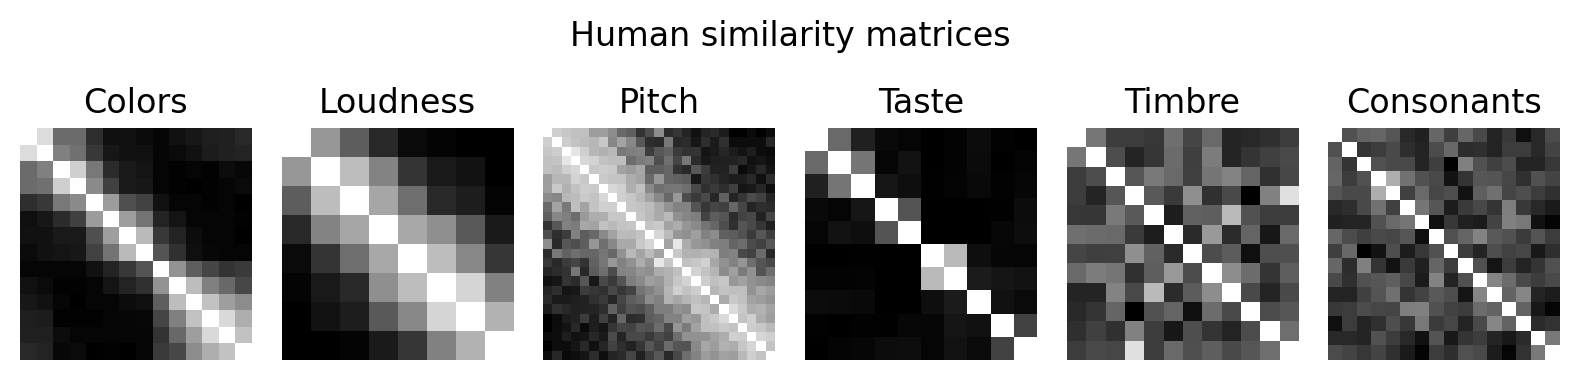

In [86]:
# @title Visualize human similarity judgments

plt.figure(figsize=(8, 2))
for i, dom in enumerate(DOMAINS):
  plt.subplot(161+i)
  plt.imshow(all_human_data[dom]['similarity'], cmap='gray')
  plt.title(TITLES[DOMAINS.index(dom)])
  plt.axis('off')

plt.suptitle('Human similarity matrices')
plt.tight_layout()
plt.show()

In [20]:
# @title Load and LLM similarity judgments
#@markdown NOTE: this cell may be slow to run due to bootstrapping loop

DATA_PATHS = [
    "color/more-colors-hex-3-text-davinci-003-0.7",
    "loudness/loudness-tone-3-text-davinci-003-0.7",
    "pitch/tones-extended-freq-3-text-davinci-003-0.7",
    "taste/taste-basic-3-text-davinci-003-0.7",
    "timbre/instruments-timbre-3-text-davinci-003-0.7",
    "vocal_consonant/vocal_consonant-newsims-3-text-davinci-003-0.7"
]

DATA_PATHS_GPT35 = [
    "color/more-colors-hex-3-gpt-35-turbo-0.7",
    "loudness/loudness-tone-3-gpt-35-turbo-0.7",
    "pitch/tones-extended-freq-3-gpt-35-turbo-0.7",
    "taste/taste-basic-3-gpt-35-turbo-0.7",
    "timbre/instruments-timbre-3-gpt-35-turbo-0.7",
    "vocal_consonant/vocal_consonant-newsims-3-gpt-35-turbo-0.7"
]

DATA_PATHS_GPT4 = [
    "color/more-colors-hex-3-gpt-4-0.7",
    "loudness/loudness-tone-3-gpt-4-0.7",
    "pitch/tones-extended-freq-3-gpt-4-0.7",
    "taste/taste-basic-3-gpt-4-0.7",
    "timbre/instruments-timbre-3-gpt-4-0.7",
    "vocal_consonant/vocal_consonant-newsims-3-gpt-4-0.7"
]

# @markdown Choose the model for which you will load similarity data.
# @markdown Model options are: `['gpt3', 'gpt35', 'gpt4']`
WHICH_MODEL = "gpt4" # @param ['gpt3', 'gpt35', 'gpt4']

# Number of machine judgments to use for analysis. Max is 10, we recommend using all 10 repetitions.
# Note that LLMs generally use stochastic autoregressive sampling with a temperature term.
# Thus there may be variability in the similarity judgments they produce -- albeit much less variation than between human subjects.
REPETITIONS = 10

all_machine_data = {}
for i, dom in enumerate(DOMAINS):
    sim_mat = 0
    for r in range(REPETITIONS):
        if WHICH_MODEL == "gpt3":
            sim_mat += np.load("gpt3-data/" + DATA_PATHS[i] + f"-{r + 1}.npy") / REPETITIONS
        elif WHICH_MODEL == "gpt35":
            sim_mat += np.load("gpt35-data/" + DATA_PATHS_GPT35[i] + f"-{r + 1}.npy") / REPETITIONS
        else:
            sim_mat += np.load("gpt4-data/" + DATA_PATHS_GPT4[i] + f"-{r + 1}.npy") / REPETITIONS
    if dom == "pitch":
        sim_mat = sim_mat[22:,22:]
    elif dom == "color":
        sim_mat = sim_mat[0:14,0:14]
    all_machine_data[dom] = {}
    all_machine_data[dom]["similarity"] = sim_mat
    all_machine_data[dom]["labels"] = np.load("human-data/" + dom + "_labels.npy")


# bootstrapping over machine data
NBOOT = 1000
all_machine_data_boots = {}
for i, dom in enumerate(DOMAINS):
    all_machine_data_boots[dom] = []
    for n in range(NBOOT):
        sim_mat = 0
        for r in range(REPETITIONS):
            if WHICH_MODEL == "gpt3":
                sim_mat += np.load("gpt3-data/" + DATA_PATHS[i] + f"-{np.random.randint(REPETITIONS) + 1}.npy") / REPETITIONS
            elif WHICH_MODEL == "gpt35":
                sim_mat += np.load("gpt35-data/" + DATA_PATHS_GPT35[i] + f"-{np.random.randint(REPETITIONS) + 1}.npy") / REPETITIONS
            else:
                sim_mat += np.load("gpt4-data/" + DATA_PATHS_GPT4[i] + f"-{np.random.randint(REPETITIONS) + 1}.npy") / REPETITIONS
        if dom == "pitch":
            sim_mat = sim_mat[22:,22:]
        elif dom == "color":
            sim_mat = sim_mat[0:14,0:14]
        all_machine_data_boots[dom].append(sim_mat)

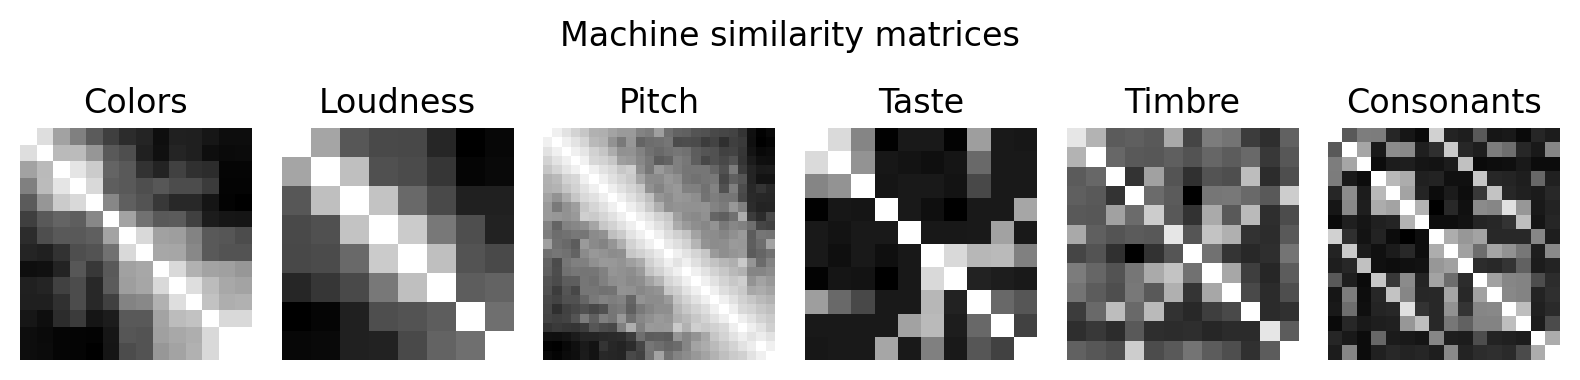

In [85]:
# @title Visualize LLM similarity judgments

plt.figure(figsize=(8, 2))
for i, dom in enumerate(DOMAINS):
  plt.subplot(161+i)
  # sns.heatmap(all_machine_data[dom]['similarity'])
  plt.imshow(all_machine_data[dom]['similarity'], cmap='gray')
  plt.title(TITLES[DOMAINS.index(dom)])
  plt.axis('off')

plt.suptitle('Machine similarity matrices')
plt.tight_layout()
plt.show()

In [93]:
# @title Correlation analysis (unused)

# # @markdown Compute Pearson's correlation between human and LLM similarity judgments for each domain.

# corr_vals = []
# corr_sds = []
# corr_raw = []
# for dom in DOMAINS:
#     vh = squareform(all_human_data[dom]["similarity"], checks = False)
#     # vm = squareform(all_machine_data[dom]["similarity"], checks = False)
#     vms = [squareform(mdat, checks = False) for mdat in all_machine_data_boots[dom]]
#     boots_corrs = [np.corrcoef(vh, vm)[0][1] for vm in vms]
#     corr_vals.append(np.mean(boots_corrs))
#     corr_sds.append(np.std(boots_corrs))
#     corr_raw.append(boots_corrs)

# corr_vals = np.array(corr_vals)
# corr_sds = np.array(corr_sds)
# dnames = np.array(TITLES.copy())
# arr1inds = corr_vals.argsort()
# dnames = dnames[arr1inds]
# corr_vals = corr_vals[arr1inds]
# corr_sds = corr_sds[arr1inds]

# fig, ax = plt.subplots(1,1,figsize=(6,6))
# loc_vals = np.array([i for i in range(len(dnames))])
# ax.bar(loc_vals, corr_vals, yerr = 1.96 * corr_sds, align='center', alpha=0.8, ecolor='black', capsize=10, color = ["tab:purple", "tab:red", "tab:green", "tab:orange", "tab:blue", "tab:cyan"])
# ax.set_xticks(loc_vals)
# ax.set_xticklabels(dnames, rotation=30, ha='right');
# ax.tick_params(axis='both', which='major', labelsize=18)
# ax.set_ylabel("Correlation (Pearson r)", fontsize = 20)

# fig.show()

In [132]:
# @title Let's convert everything into a dataframe to use R
# @markdown We will attempt to use some of the packages we've used in class.
all_dfs = []  # DF for each domain, which we will concat

for dom in DOMAINS:
  # Similarity matrices are mostly symmetric -- sim(a, b) = sim(b, a)
  # Though this is not always the case for all stimuli.
  # See classic paper: https://psycnet.apa.org/record/1978-09287-001
  # However for the stimuli in this dataset the similarities are indeed mostly symmetric
  # for this reason we will dedupe the data -- and consider only sim(a, b) and discard sim(b, a).
  # This can be done w/ the squareform func which creates a compact array
  df = pd.DataFrame({
      'human_data': squareform(all_human_data[dom]['similarity'], checks = False),
      'machine_data': squareform(all_machine_data[dom]['similarity'], checks = False),
      'domain': dom,
  })
  all_dfs.append(df)

df = pd.concat(all_dfs)
df

,human_data,machine_data,domain
0,0.860000,0.870000,color
1,0.420000,0.635000,color
2,0.420000,0.505000,color
3,0.180000,0.360000,color
4,0.060000,0.250000,color
...,...,...,...
115,0.333333,0.265000,vocal_consonant
116,0.279762,0.299074,vocal_consonant
117,0.386905,0.255000,vocal_consonant
118,0.407407,0.407407,vocal_consonant


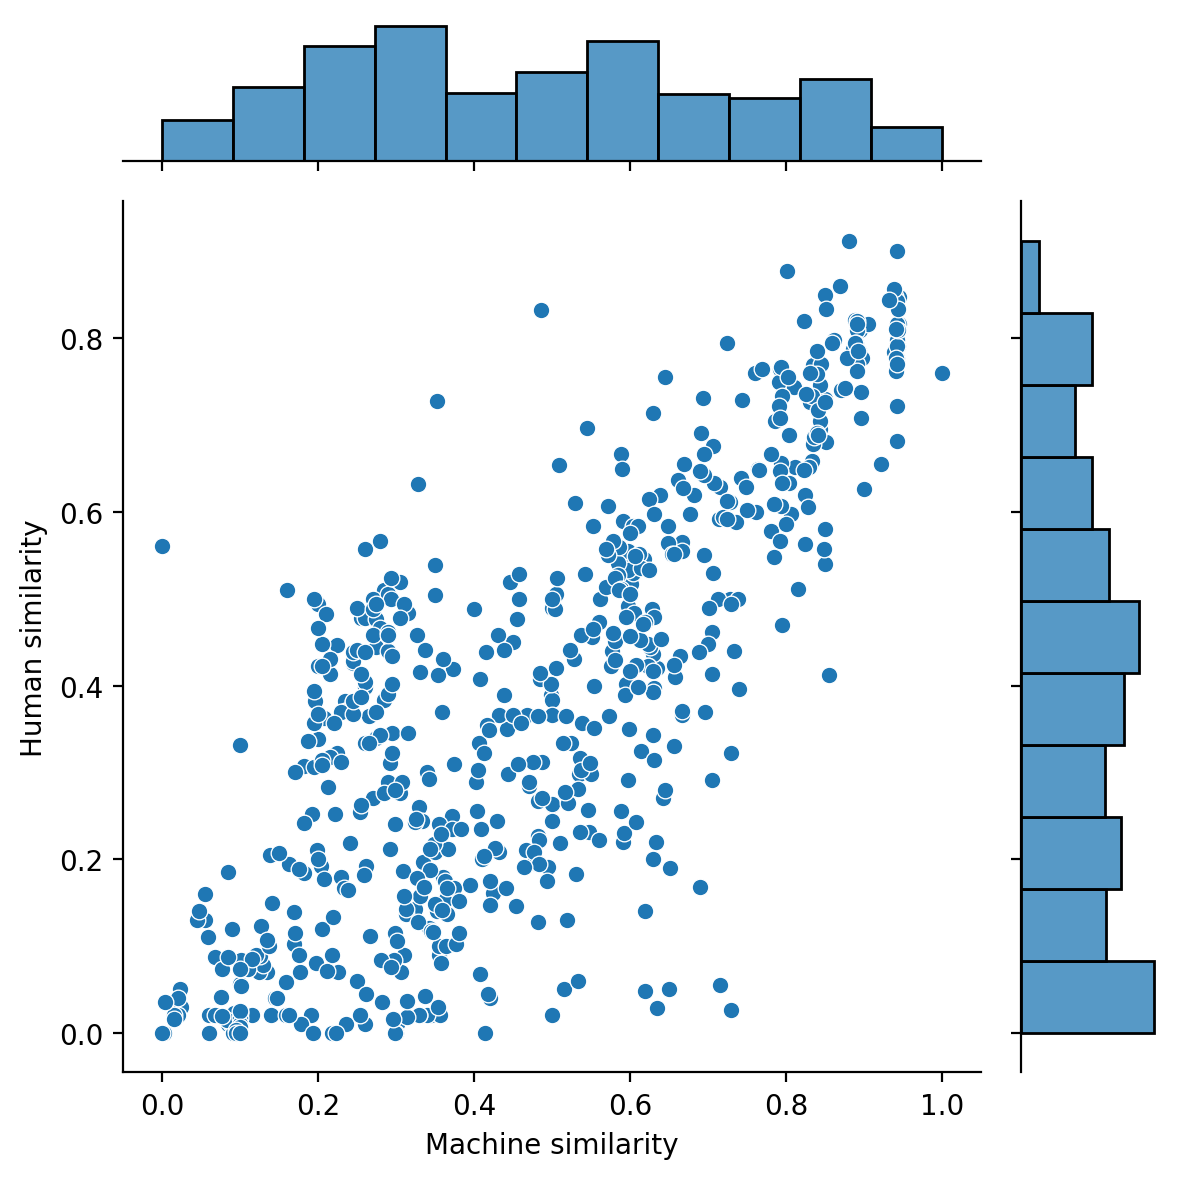

In [103]:
#@title Scatterplot / regression plot

plottype = 'jointplot' #@param ['jointplot', 'regplot']
getattr(sns, plottype)(data=df, x='machine_data', y='human_data')
plt.xlabel('Machine similarity')
plt.ylabel('Human similarity')
plt.tight_layout()
plt.show()

In [134]:
# @title Run correlation test
%%R -i df

cor_test(df, y="human_data", x="machine_data")

Parameter1   | Parameter2 |    r |       95% CI | t(648) |         p
--------------------------------------------------------------------
machine_data | human_data | 0.79 | [0.76, 0.82] |  33.08 | < .001***

Observations: 650


/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [135]:
# @title Fit a regression line and describe it
%%R -i df

model = lm(human_data ~ machine_data, data=df)
# model %>% tidy()
print(model)

report(model)


Call:
lm(formula = human_data ~ machine_data, data = df)

Coefficients:
 (Intercept)  machine_data  
     0.02027       0.75906  



/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



We fitted a linear model (estimated using OLS) to predict human_data with
machine_data (formula: human_data ~ machine_data). The model explains a
statistically significant and substantial proportion of variance (R2 = 0.63,
F(1, 648) = 1094.50, p < .001, adj. R2 = 0.63). The model's intercept,
corresponding to machine_data = 0, is at 0.02 (95% CI [-4.03e-03, 0.04], t(648)
= 1.64, p = 0.102). Within this model:

  - The effect of machine data is statistically significant and positive (beta =
0.76, 95% CI [0.71, 0.80], t(648) = 33.08, p < .001; Std. beta = 0.79, 95% CI
[0.75, 0.84])

Standardized parameters were obtained by fitting the model on a standardized
version of the dataset. 95% Confidence Intervals (CIs) and p-values were
computed using a Wald t-distribution approximation.


## Check for normality, linearity, heteroskedasticity

Check if the relationship between human and machine similarity juddments is linear and if pearson correlation is a good measure of association.
Mostly looks good. Similarity judgments are bounded between 0 and 1 so the error pattern of the risiduals at the extremes may violate assumptions a bit. Perhaps it makes sense to use a logit transformation on the similarity judgments: [0, 1] -> (-inf, inf).

/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



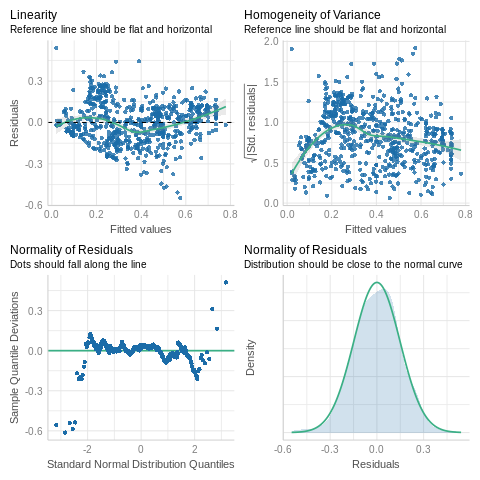

In [136]:
%%R -i df

performance::check_model(model, check=c("normality", "linearity", "homogeneity", "qq", "vif"))

# Visual vs non-visual

In [144]:
# Create a binary factor
df['visual'] = df['domain'] == 'color'

# Deviation coding
df['visual_dev'] = df.visual - 0.5

# Dummy coding
df['visual_dum'] = df.visual.astype(float)

# Centering
df['machine_data_c'] = df.machine_data - df.machine_data.mean()
df['human_data_c'] = df.human_data - df.human_data.mean()

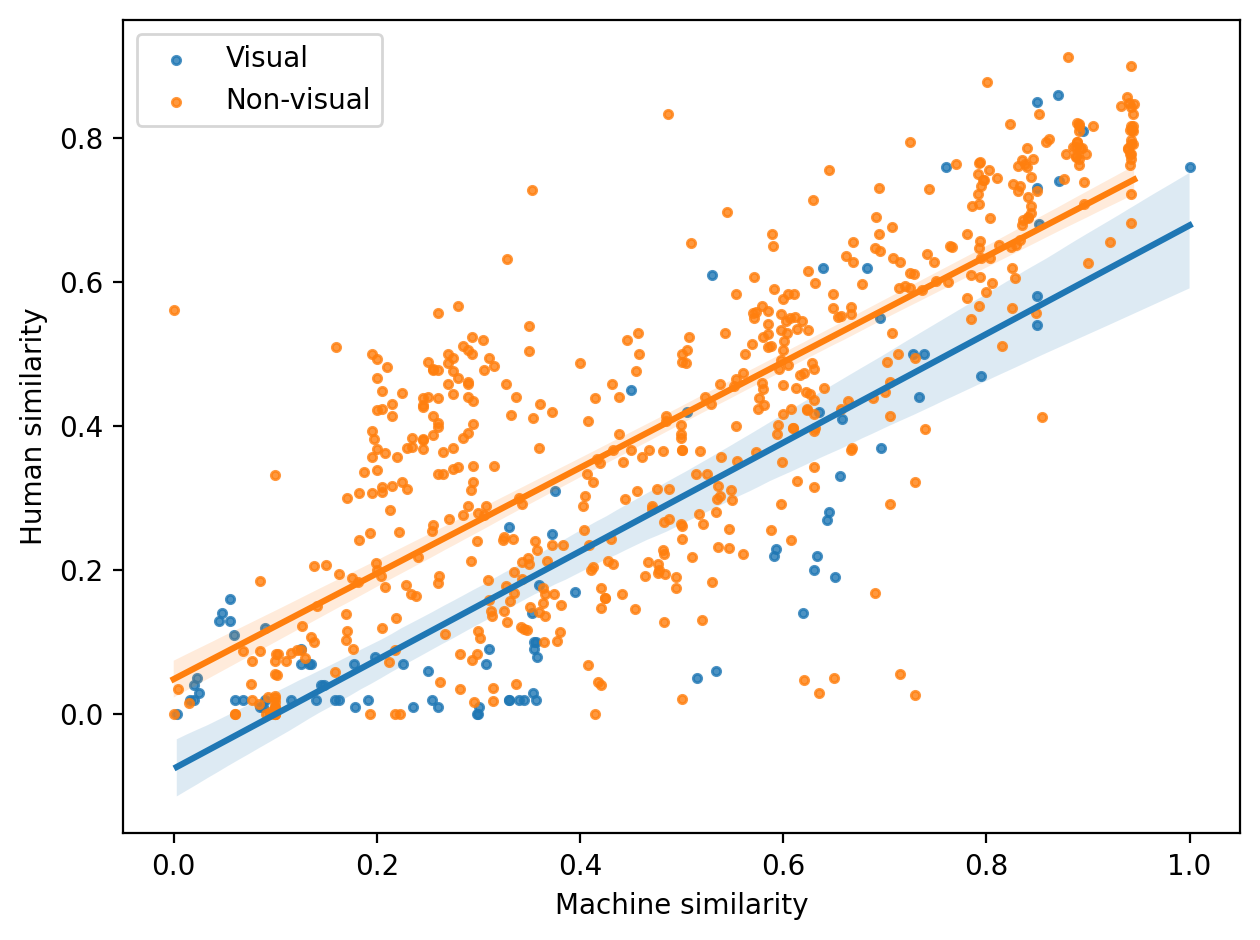

In [140]:
#@title Scatterplot / regression plot

sns.regplot(data=df[df.visual], x='machine_data', y='human_data', label='Visual', marker='.')
sns.regplot(data=df[~df.visual], x='machine_data', y='human_data', label='Non-visual', marker='.')
plt.xlabel('Machine similarity')
plt.ylabel('Human similarity')
plt.legend()
plt.tight_layout()
plt.show()

In [145]:
#@title Visual vs non-visual stimuli

%%R -i df

model <- lm(human_data ~ machine_data_c * visual_dum, df)

print(model)
report(model)


Call:
lm(formula = human_data ~ machine_data_c * visual_dum, data = df)

Coefficients:
              (Intercept)             machine_data_c  
                  0.39745                    0.73354  
               visual_dum  machine_data_c:visual_dum  
                 -0.11440                    0.02054  



/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



We fitted a linear model (estimated using OLS) to predict human_data with
machine_data_c and visual_dum (formula: human_data ~ machine_data_c *
visual_dum). The model explains a statistically significant and substantial
proportion of variance (R2 = 0.65, F(3, 646) = 408.60, p < .001, adj. R2 =
0.65). The model's intercept, corresponding to machine_data_c = 0 and
visual_dum = 0, is at 0.40 (95% CI [0.39, 0.41], t(646) = 65.34, p < .001).
Within this model:

  - The effect of machine data c is statistically significant and positive (beta
= 0.73, 95% CI [0.69, 0.78], t(646) = 29.98, p < .001; Std. beta = 0.77, 95% CI
[0.72, 0.81])
  - The effect of visual dum is statistically significant and negative (beta =
-0.11, 95% CI [-0.15, -0.08], t(646) = -6.75, p < .001; Std. beta = -0.16, 95%
CI [-0.21, -0.12])
  - The effect of machine data c × visual dum is statistically non-significant
and positive (beta = 0.02, 95% CI [-0.10, 0.14], t(646) = 0.34, p = 0.733; Std.
beta = 7.45e-03, 95% CI [-0.

In [154]:
%%R
#@title Power analysis

WebPower::wp.regression(n=650, p1=2, p2=0, alpha=.05, power=.9)

Power for multiple regression

      n p1 p2         f2 alpha power
    650  2  0 0.01957073  0.05   0.9

URL: http://psychstat.org/regression
